<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimmental/eigen_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install quandl

In [17]:
import quandl
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint
from quandl.errors.quandl_error import NotFoundError
from sklearn.decomposition import PCA

In [18]:
def download_from_BSE(datadump,startdate):
    data= {}
    df=pd.DataFrame()
    
    print(f'len of datadump {len(datadump)}')
    try:
      for i in range(len(datadump)):
          data[datadump[i]]= quandl.get('BSE/BOM'+datadump[i],start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")['Close']
          
          
      i=0
      for key , value in data.items():
        df.insert(i, key, value)
        i=i+1
    except NotFoundError:
      print('Not Found')

    return df

In [19]:
def get_bse_sector_list(data):

 
  url_github='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'
  files= {1:'LargeCap.csv',2:'MidCap.csv',3:'SmallCap.csv'}
  if data=='LargeCap':
    url=url_github+files[1]
  if data=='MidCap':
    url=url_github+files[2]
  if data == 'SmallCap':
    url=url_github+files[3]
  #if data=='Energy':
  #  url =url_github+files[9]
  dataframe = pd.read_csv(url,sep=',') 
  scrip_code=dataframe['Scrip Code'].tolist()
  scrip_code = [str(i) for i in scrip_code]
  return scrip_code

In [20]:
#@title Rejected Scrips
rejectlst= ['543253','543213','543210','543233','543252','543249','543212','543242','543248','543066','543232','542759','543223','543238',\
            '543243','543235','543245','543220','543237','543240','543227','543228','543066',\
            ]

In [21]:
data='LargeCap'
startdate='2019-01-01'

In [22]:
datadump=get_bse_sector_list(data)
datadump=[i for i in datadump if i not in rejectlst]
data=download_from_BSE(datadump,startdate)
data_copy=data.copy()
print(data.shape)

len of datadump 80
(743, 80)


In [40]:
data_copy.tail(2)

,500325,532454,532488,500470,532538,500875,500510,517354,532898,500302,526371,534816,500440,500300,524804,524715,532868,500180,540376,500820,500257,500228,500295,540777,507685,500182,517334,500570,500087,500696,540133,500124,532461,532424,500790,532321,500104,500547,532155,532522,512070,500034,500247,540755,541729,570001,500520,532500,530965,500312,500331,500530,540719,500188,532977,539448,500425,500550,500825,500096,533278,500114,532134,500387,531642,500010,500112,532755,540716,532555,532187,505200,532540,541153,532215,532921,532978,532281,532174,500209
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-28,2397.70,680.05,4524.70,1127.4,7405.20,219.95,1899.40,1400.00,205.45,2599.00,132.7,247.65,457.8,1621.4,725.15,815.0,385.75,1460.90,4722.05,3367.15,916.7,658.0,344.9,642.15,705.4,2418.35,218.1,480.1,933.40,2310.20,563.75,4743.40,37.20,968.1,19353.10,458.10,294.3,380.40,133.05,217.35,762.1,6904.85,1775.65,135.80,2418.40,236.3,838.70,7297.1,112.25,139.45,2472.05,16695.35,1178.50,317.0,3176.5,2001.8,380.1,2405.25,3548.55,562.45,148.9,2380.30,80.80,26740.95,500.2,2566.60,460.95,1806.25,1387.85,124.15,852.70,2479.30,3707.30,253.65,675.4,729.10,16102.15,1284.3,736.05,1887.45
2021-12-29,2403.05,676.65,4619.75,1116.1,7427.55,216.80,1892.35,1393.55,204.35,2614.35,131.4,244.80,454.1,1603.3,726.65,838.3,385.65,1453.65,4682.25,3369.00,928.9,655.5,339.4,644.55,703.4,2435.80,218.4,475.8,935.25,2307.25,555.30,4830.55,37.15,960.8,19404.05,469.45,292.3,381.45,132.30,217.10,758.1,6912.15,1764.65,134.95,2419.85,233.3,832.35,7344.6,111.50,138.85,2450.30,16656.55,1181.05,315.7,3262.4,2009.3,375.5,2380.05,3556.05,566.70,146.8,2401.55,80.95,26660.15,502.6,2563.05,454.25,1786.65,1382.75,123.05,869.65,2562.45,3693.15,250.05,670.3,722.65,16241.75,1292.0,735.65,1885.05


In [23]:
style.use("ggplot")

In [24]:
# Daily Linear Returns (%)
datareturns = data.pct_change(1)

In [25]:
# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

In [26]:
# Normalizing the Log returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)

No handles with labels found to put in legend.


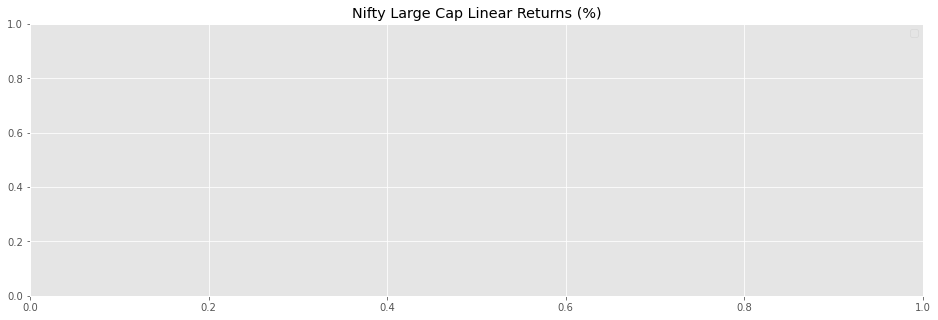

In [28]:
# Visualizing Log Returns for the DJIA 
plt.figure(figsize=(16, 5))
plt.title("Nifty Large Cap Linear Returns (%)")
#data.DJIA.plot()
plt.grid(True);
plt.legend()
plt.show()

In [41]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values
n_tickers = len(stock_tickers)

In [42]:
n_tickers

80

In [43]:
# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

In [44]:
# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != 'DJIA'].cov()
pca = PCA()
pca.fit(cov_matrix)

PCA()

31 principal components explain 95.00% of variance


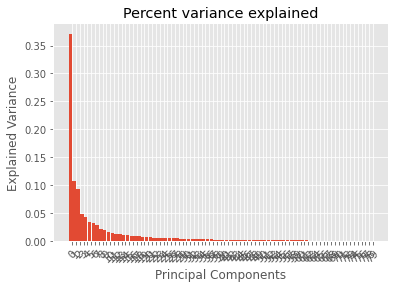

In [45]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [46]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

In [47]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


Eigen portfolio #42 with the highest Sharpe. Return nan%, vol = 697.65%, Sharpe = nan
           Return         Vol         Sharpe
27  2.182743e+266  425.130267  5.134293e+263
31   3.674136e+01    1.408645   2.608277e+01
6    4.328555e+01    2.470670   1.751976e+01
15   2.821302e+00    0.631055   4.470769e+00
13   1.709531e+00    0.398437   4.290593e+00
45   1.681127e+00    0.441747   3.805635e+00
7    1.402016e+00    0.484121   2.896006e+00
22   2.847386e+00    1.043851   2.727771e+00
19   1.238468e+00    0.468810   2.641730e+00
37   8.934897e-01    0.383260   2.331291e+00


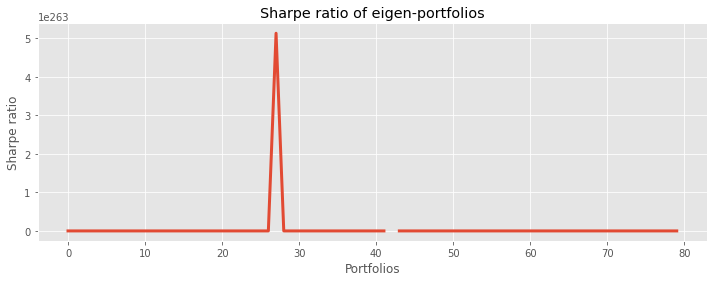

In [48]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers[:80])
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


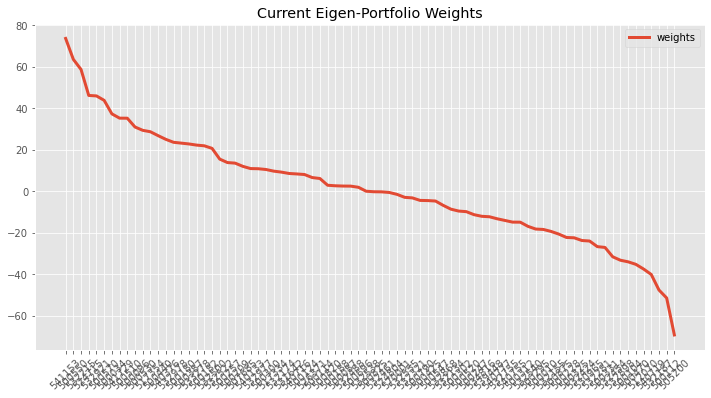

,weights
541153,73.727727
500550,63.631953
532215,58.737043
524715,46.215439
532921,45.987804
...,...
512070,-37.541410
540719,-40.173036
532187,-47.668342
500112,-51.526252


In [49]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 28.46%
Volatility = 85.38%
Sharpe = 0.33


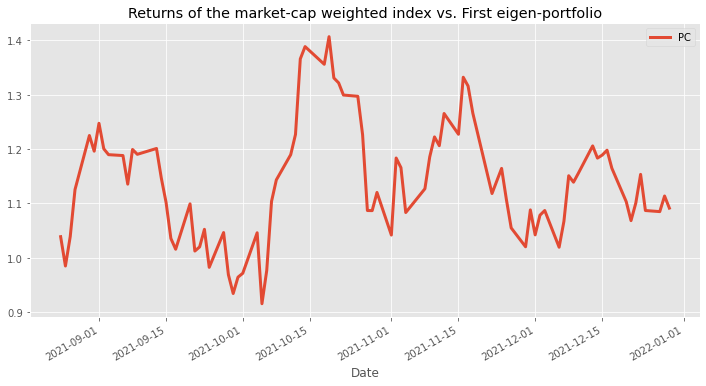

In [51]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns}, index=X_test.index) #'DJIA': X_test_raw.loc[:, 'DJIA']
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))